In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import datetime as dt
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
random.seed(100)

In [3]:
# define parameters
batch_size = 32
minimum_len = 128
epochs = 200
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'

### Getting file names

In [4]:
#currdir= os.getcwd()
rootdir = '/home/taejoon/PhysioNetChallenge'
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Mel_data_20200402_128' 
mel_directory = os.path.join(rootdir, mel_name)
results_directory = os.path.join(rootdir, 'results')
#save_directory = os.path.join(currdir, '')
if not os.path.isdir(input_directory):
        os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
        os.mkdir(mel_directory)
if not os.path.isdir(results_directory):
        os.mkdir(results_directory)                       

In [5]:
# Find files
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)

In [6]:
input_file_names = sorted(input_files)
input_file_names

['A0001.mat',
 'A0002.mat',
 'A0003.mat',
 'A0004.mat',
 'A0005.mat',
 'A0006.mat',
 'A0007.mat',
 'A0008.mat',
 'A0009.mat',
 'A0010.mat',
 'A0011.mat',
 'A0012.mat',
 'A0013.mat',
 'A0014.mat',
 'A0015.mat',
 'A0016.mat',
 'A0017.mat',
 'A0018.mat',
 'A0019.mat',
 'A0020.mat',
 'A0021.mat',
 'A0022.mat',
 'A0023.mat',
 'A0024.mat',
 'A0025.mat',
 'A0026.mat',
 'A0027.mat',
 'A0028.mat',
 'A0029.mat',
 'A0030.mat',
 'A0031.mat',
 'A0032.mat',
 'A0033.mat',
 'A0034.mat',
 'A0035.mat',
 'A0036.mat',
 'A0037.mat',
 'A0038.mat',
 'A0039.mat',
 'A0040.mat',
 'A0041.mat',
 'A0042.mat',
 'A0043.mat',
 'A0044.mat',
 'A0045.mat',
 'A0046.mat',
 'A0047.mat',
 'A0048.mat',
 'A0049.mat',
 'A0050.mat',
 'A0051.mat',
 'A0052.mat',
 'A0053.mat',
 'A0054.mat',
 'A0055.mat',
 'A0056.mat',
 'A0057.mat',
 'A0058.mat',
 'A0059.mat',
 'A0060.mat',
 'A0061.mat',
 'A0062.mat',
 'A0063.mat',
 'A0064.mat',
 'A0065.mat',
 'A0066.mat',
 'A0067.mat',
 'A0068.mat',
 'A0069.mat',
 'A0070.mat',
 'A0071.mat',
 'A007

### Code for extracting only single-label subjects

In [7]:
# Find unique number of classes  
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())

    return sorted(unique_classes)

unique_classes = get_unique_classes(input_directory, input_files)
# Creating one-hot vector for Y
# num = np.unique(classes, axis=0)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
#class2index

def one_hot_encoding(one_hot_vector,y, class2index):

       ind=class2index[y]
       one_hot_vector[ind]=1
       return one_hot_vector

In [8]:
class2index

{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}

In [9]:
# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

In [10]:
classes_orig= [x.replace('.mat', '.hea') for x in input_file_names] # total subjects
classes_multi, _, _ = searching_overlap(input_directory,class2index, input_file_names)
classes_single = [x for x in classes_orig if x not in classes_multi]
classes_single = [x.replace('.hea', '.mat') for x in classes_single]

In [11]:
np.shape(classes_single)

(6401,)

In [12]:
classes_single

['A0001.mat',
 'A0002.mat',
 'A0003.mat',
 'A0004.mat',
 'A0005.mat',
 'A0006.mat',
 'A0007.mat',
 'A0008.mat',
 'A0009.mat',
 'A0010.mat',
 'A0011.mat',
 'A0012.mat',
 'A0013.mat',
 'A0014.mat',
 'A0015.mat',
 'A0016.mat',
 'A0017.mat',
 'A0018.mat',
 'A0019.mat',
 'A0020.mat',
 'A0021.mat',
 'A0022.mat',
 'A0023.mat',
 'A0024.mat',
 'A0025.mat',
 'A0026.mat',
 'A0027.mat',
 'A0028.mat',
 'A0029.mat',
 'A0030.mat',
 'A0031.mat',
 'A0032.mat',
 'A0033.mat',
 'A0034.mat',
 'A0035.mat',
 'A0036.mat',
 'A0037.mat',
 'A0038.mat',
 'A0039.mat',
 'A0040.mat',
 'A0041.mat',
 'A0042.mat',
 'A0044.mat',
 'A0045.mat',
 'A0046.mat',
 'A0047.mat',
 'A0048.mat',
 'A0049.mat',
 'A0050.mat',
 'A0051.mat',
 'A0052.mat',
 'A0053.mat',
 'A0054.mat',
 'A0055.mat',
 'A0056.mat',
 'A0057.mat',
 'A0058.mat',
 'A0059.mat',
 'A0060.mat',
 'A0061.mat',
 'A0062.mat',
 'A0063.mat',
 'A0064.mat',
 'A0065.mat',
 'A0066.mat',
 'A0067.mat',
 'A0068.mat',
 'A0069.mat',
 'A0070.mat',
 'A0071.mat',
 'A0072.mat',
 'A007

In [13]:
# double-checking if classes_single have single-label
a, b, c  = searching_overlap(input_directory,class2index,classes_single)
a

[]

In [14]:
# we can safely use classes_single as input_file_names
input_file_names = classes_single
random.shuffle(input_file_names)
np.shape(input_file_names)

(6401,)

### Shuffle and divide files into train/eval/test

In [15]:
data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True)
data_train, data_val = train_test_split(data, test_size = 0.25, train_size = 0.75, shuffle=True)

In [16]:
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

(3840,) (1280,) (1281,)


### CNN Model

In [17]:
from keras.applications.densenet import DenseNet169
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model 

input_tensor = Input(shape=(128, 128, 12))
base_model = DenseNet169(input_tensor=input_tensor, weights=None, include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
pred = Dense(9, activation=activation_function)(x)

model = Model(inputs=base_model.input, outputs=pred)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 12) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 12) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   37632       zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [19]:
def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)    
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

In [20]:
def exploratory_look(input_directory,file, class2index):
    
    classes = []

    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp            

for file in input_file_names:
    tmp = exploratory_look(input_directory, file, class2index)

['Normal\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STE\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['LBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STE\n'] 1
['Normal\n'] 1
['LBBB\n'] 1
['STD\n'] 1
['

['Normal\n'] 1
['STD\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['STD\n'] 1
['AF\n'] 1
['STD\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STD\n'] 1
['AF\n'] 1
['STD\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['Normal\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PVC\n'] 1
['AF\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['LBBB\n'] 1
['PVC\n'] 

['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['STD\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STE\n'] 1
['Normal\n'] 1
['STD\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STE\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['AF\n'] 1
['PAC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['STD\n'] 1

['I-AVB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['Normal\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['AF\n'] 1
['AF\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['STE\n'] 1
['STD\n'] 1
['PVC\n'] 1
['STD\n'] 1
['AF\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1


['Normal\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['LBBB\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['STD\n'] 1
['AF\n'] 1
['Normal\n'

['PVC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STE\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STE\n'] 1
['PAC\n'] 1
['STD\n'] 1
['STD\n'] 1
['PAC\n'] 1
['STD\n'] 1
['Normal\n'] 1
['STD\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['AF\n'] 1
['Normal\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['Normal\n'] 1

['AF\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['AF\n'] 1
['AF\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\

['PVC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['AF\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STE\n'] 1
['AF\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
[

['PVC\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['PVC\n'] 1
['STD\n'] 1
['Normal\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['AF\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STD\n'] 1
['AF\n'] 1
['STE\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['AF\

In [21]:
# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

In [22]:
def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len): # step = 0, 1, 2, 3....
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    
    # 여기서 두 번째 셔플 
    random.shuffle(curr_file_indices)
    
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        mel_files.append(clip_file)
        
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    return mel_files, classes

In [23]:
def randextract_mels2(data, mel_directory, class2index, minimum_len): # step = 0, 1, 2, 3....
    tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    clip_file = block_feature(tmp_file, minimum_len)
    mel_file = clip_file
        
    label = get_labels(input_directory, file, class2index)
    classes = label
    return mel_files, classes

In [24]:
model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [25]:
def train(data_train, mel_directory, batch_size, class2index, minimum_len): 
    
    loss=[]
    acc = []
    # 여기서 첫 번째로 셔플하고 
    random.shuffle(data_train)
    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps):
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
#         print(np.shape(batch_labels))
        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss.append(train_tmp[0])
        acc.append(train_tmp[1])

    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    return loss, acc

In [26]:
def test(data, mel_directory, input_directory, class2index, minimum_len, model): 
    # 1. 파일 읽어오기
    # 2. 128 길이의 block들로 쪼개기 (끄트머리 버리기-> np.floor)
    # 3. 각 block -> model.predict -> logit 가져오기 
    # 4. Block들간 평균내서 1 or 0 부여
    # 5. 실제 label과 비교 

    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    for i, file in enumerate(data):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        logits=[]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            curr_block = tmp_file[start:end]
            curr_block = np.expand_dims(curr_block,0)

            logit = model.predict(curr_block) # sigmoid 거쳐서 나온 것
            logits.append(logit)

        average = np.mean(np.squeeze(logits), axis=0)
        scores.append(average)
#         average[average>=0.5] = 1
#         average[average<0.5] = 0
        pred_ans = np.argmax(average)
    
        if average[average<0]:
            print('Error: output of sigmoid should be between 0 and 1')
#         predicted_labels.append(average)    
        predicted_labels.append(pred_ans)
        true_label = get_labels(input_directory, file, class2index)
        true_ans = np.argmax(true_label)
#         if np.array_equal(average, true_label): # predicted와 실제 label이 아예 같아야만 정답으로 인정
        if int(true_ans) == int(pred_ans):
            accuracy[i] = 1

    avg_acc = np.mean(accuracy)
    return avg_acc, scores, predicted_labels

In [27]:
def test2(data, mel_directory, input_directory, class2index, minimum_len, model): # this function uses test_on_batch
    # 1. 파일 읽어오기
    # 2. 128 길이의 block들로 쪼개기 (끄트머리 버리기-> np.floor)
    # 3. 각 block -> model.predict -> logit 가져오기 
    # 4. Block들간 평균내서 1 or 0 부여
    # 5. 실제 label과 비교 

    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    total_loss=[]
    total_acc=[]
    for i, file in enumerate(data):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        loss=[]
        acc=[]
        y_true = get_labels(input_directory, file, class2index)
        y_true = np.transpose(np.expand_dims(y_true,1))
#         for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
#             start = block*minimum_len
#             end = (block+1)*minimum_len
        curr_block = tmp_file[:minimum_len]
        curr_block = np.expand_dims(curr_block,0)


        test_tmp = model.test_on_batch(curr_block, y_true)
        loss.append(test_tmp[0])
        acc.append(test_tmp[1])
        total_loss.append(np.mean(np.array(loss)))
        total_acc.append(np.mean(np.array(acc)))
        

    avg_acc = np.mean(np.array(total_acc))
    avg_loss = np.mean(np.array(total_loss))
    return avg_loss, avg_acc
# avg_acc, scores, predicted_labels

In [42]:
def test3(data, mel_directory, input_directory, class2index, minimum_len, model): # this function uses test_on_batch
    # 1. 파일 읽어오기
    # 2. 128 길이의 block들로 쪼개기 (끄트머리 버리기-> np.floor)
    # 3. 각 block -> model.predict -> logit 가져오기 
    # 4. Block들간 평균내서 1 or 0 부여
    # 5. 실제 label과 비교 

    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    total_loss=[]
    total_acc=[]
    for i, file in enumerate(data):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        loss=[]
        acc=[]
        y_true = get_labels(input_directory, file, class2index)
        y_true = np.transpose(np.expand_dims(y_true,1))
#         for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
#             start = block*minimum_len
#             end = (block+1)*minimum_len
        curr_block = tmp_file[:minimum_len]
        curr_block = np.expand_dims(curr_block,0)

        test_tmp = model.predict_on_batch(curr_block)
#         test_tmp = model.test_on_batch(curr_block, y_true)
#         loss.append(test_tmp[0])
#         acc.append(test_tmp[1])
#         total_loss.append(np.mean(np.array(loss)))
#         total_acc.append(np.mean(np.array(acc)))
        scores.append(test_tmp)
        pred_ans = np.argmax(test_tmp)
        predicted_labels.append(pred_ans)
#     avg_acc = np.mean(np.array(total_acc))
#     avg_loss = np.mean(np.array(total_loss))
    return predicted_labels, scores

In [28]:
val_acc_sum=[]
train_loss_sum=[]
train_acc_sum=[]
val_loss_sum=[] 
for num_epoch in range(epochs):
    train_loss, train_acc = train(data_train, mel_directory, batch_size, class2index, minimum_len)
    print('\nEpoch',num_epoch+1,'train_loss:',f'{train_loss:.3f}','train_acc:',f'{train_acc:.3f}',"\t", dt.datetime.now())
    model_output = "ecg_mel_E%02dL%.2f" % (num_epoch, train_loss)
    save_name = os.path.join(results_directory, model_output)
    
    val_loss, val_acc = test2(data_val, mel_directory, input_directory, class2index, minimum_len, model)
    print('\nValidation', num_epoch+1,'valid_loss:',f'{val_loss:.3f}','valid_acc:',f'{val_acc:.3f}',"\t", dt.datetime.now()) 
#     val_acc, _, _ = test(data_val, mel_directory, input_directory, class2index, minimum_len, model)
#     print('\nValidation', num_epoch+1,'valid_acc:',f'{val_acc:.3f}',"\t", dt.datetime.now()) 
    val_acc_sum.append(val_acc)
    val_loss_sum.append(val_loss)
    train_loss_sum.append(train_loss)
    train_acc_sum.append(train_acc)

#     model.save(save_name)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1 train_loss: 1.828 train_acc: 0.342 	 2020-04-14 07:52:23.547106

Validation 1 valid_loss: 9.233 valid_acc: 0.164 	 2020-04-14 07:52:48.302164

Epoch 2 train_loss: 1.456 train_acc: 0.495 	 2020-04-14 07:53:07.006683

Validation 2 valid_loss: 6.062 valid_acc: 0.246 	 2020-04-14 07:53:29.557374

Epoch 3 train_loss: 1.304 train_acc: 0.551 	 2020-04-14 07:53:48.229267

Validation 3 valid_loss: 5.951 valid_acc: 0.164 	 2020-04-14 07:54:10.826564

Epoch 4 train_loss: 1.205 train_acc: 0.590 	 2020-04-14 07:54:29.531422

Validation 4 valid_loss: 2.061 valid_acc: 0.311 	 2020-04-14 07:54:52.140111

Epoch 5 train_loss: 1.103 train_acc: 0.623 	 2020-04-14 07:55:10.881842

Validation 5 valid_loss: 2.913 valid_acc: 0.226 	 2020-04-14 07:55:33.596847

Epoch 6 train_loss: 1.036 train_acc: 0.653 	 2020-04-14 07:55:52.337945

Validation 6 valid_loss: 2.633 valid_acc: 0.363 	 2020-04-14 07:56:15.064416



Epoch 53 train_loss: 0.175 train_acc: 0.939 	 2020-04-14 08:28:21.290412

Validation 53 valid_loss: 6.777 valid_acc: 0.266 	 2020-04-14 08:28:44.017700

Epoch 54 train_loss: 0.168 train_acc: 0.938 	 2020-04-14 08:29:02.803627

Validation 54 valid_loss: 3.089 valid_acc: 0.557 	 2020-04-14 08:29:25.512220

Epoch 55 train_loss: 0.177 train_acc: 0.944 	 2020-04-14 08:29:44.285155

Validation 55 valid_loss: 2.096 valid_acc: 0.610 	 2020-04-14 08:30:07.072951

Epoch 56 train_loss: 0.164 train_acc: 0.942 	 2020-04-14 08:30:25.851299

Validation 56 valid_loss: 3.662 valid_acc: 0.452 	 2020-04-14 08:30:48.444140

Epoch 57 train_loss: 0.147 train_acc: 0.945 	 2020-04-14 08:31:07.247075

Validation 57 valid_loss: 4.661 valid_acc: 0.359 	 2020-04-14 08:31:29.888877

Epoch 58 train_loss: 0.158 train_acc: 0.944 	 2020-04-14 08:31:48.687484

Validation 58 valid_loss: 5.846 valid_acc: 0.306 	 2020-04-14 08:32:11.362414

Epoch 59 train_loss: 0.164 train_acc: 0.945 	 2020-04-14 08:32:30.135556

Validat


Validation 106 valid_loss: 4.878 valid_acc: 0.419 	 2020-04-14 09:05:23.423639

Epoch 107 train_loss: 0.085 train_acc: 0.974 	 2020-04-14 09:05:42.220634

Validation 107 valid_loss: 2.451 valid_acc: 0.606 	 2020-04-14 09:06:04.907141

Epoch 108 train_loss: 0.084 train_acc: 0.970 	 2020-04-14 09:06:23.736892

Validation 108 valid_loss: 3.137 valid_acc: 0.561 	 2020-04-14 09:06:46.334326

Epoch 109 train_loss: 0.079 train_acc: 0.977 	 2020-04-14 09:07:05.114815

Validation 109 valid_loss: 4.896 valid_acc: 0.394 	 2020-04-14 09:07:27.826968

Epoch 110 train_loss: 0.074 train_acc: 0.974 	 2020-04-14 09:07:46.624214

Validation 110 valid_loss: 2.820 valid_acc: 0.565 	 2020-04-14 09:08:09.349411

Epoch 111 train_loss: 0.089 train_acc: 0.971 	 2020-04-14 09:08:28.153858

Validation 111 valid_loss: 3.322 valid_acc: 0.595 	 2020-04-14 09:08:50.931603

Epoch 112 train_loss: 0.092 train_acc: 0.970 	 2020-04-14 09:09:09.738423

Validation 112 valid_loss: 2.307 valid_acc: 0.577 	 2020-04-14 09:09:


Validation 159 valid_loss: 4.047 valid_acc: 0.533 	 2020-04-14 09:42:02.441774

Epoch 160 train_loss: 0.058 train_acc: 0.985 	 2020-04-14 09:42:21.248093

Validation 160 valid_loss: 6.392 valid_acc: 0.398 	 2020-04-14 09:42:44.055976

Epoch 161 train_loss: 0.058 train_acc: 0.981 	 2020-04-14 09:43:02.845925

Validation 161 valid_loss: 5.664 valid_acc: 0.400 	 2020-04-14 09:43:25.553154

Epoch 162 train_loss: 0.057 train_acc: 0.982 	 2020-04-14 09:43:44.354557

Validation 162 valid_loss: 5.040 valid_acc: 0.415 	 2020-04-14 09:44:07.214789

Epoch 163 train_loss: 0.047 train_acc: 0.984 	 2020-04-14 09:44:26.018084

Validation 163 valid_loss: 4.365 valid_acc: 0.500 	 2020-04-14 09:44:48.764132

Epoch 164 train_loss: 0.052 train_acc: 0.983 	 2020-04-14 09:45:07.572891

Validation 164 valid_loss: 2.492 valid_acc: 0.668 	 2020-04-14 09:45:30.582055

Epoch 165 train_loss: 0.054 train_acc: 0.983 	 2020-04-14 09:45:49.380683

Validation 165 valid_loss: 3.255 valid_acc: 0.559 	 2020-04-14 09:46:

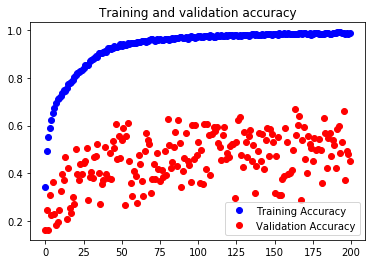

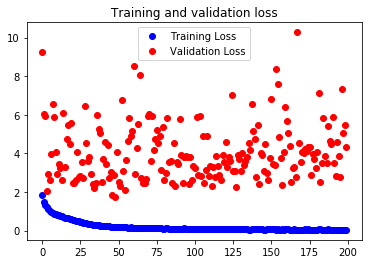

In [32]:
x_range = range(epochs)
plt.plot(x_range, train_acc_sum, 'bo', label='Training Accuracy')
plt.plot(x_range, val_acc_sum, 'ro', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(x_range, train_loss_sum, 'bo', label='Training Loss')
plt.plot(x_range, val_loss_sum, 'ro', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Now, test with test data

In [ ]:
# Scoring:

# For each 12-lead ECG recording, your algorithm must identify a set of one or more classes as well as a probability or confidence score for each class. 

# Example: 
# #Record ID
#  AF, I-AVB, LBBB, Normal, RBBB, PAC,  PVC,  STD, STE
#   1,     1,    0,      0,    0,   0,   0,     0,   0
# 0.9,   0.6,  0.2,   0.05,  0.2, 0.35, 0.35, 0.1, 0.1

Since some recordings may have multiple labels, we normalize their contributions to these scoring functions so that each recording, not each class, makes an equal contribution. For example, if a recording has six classes, and your classifier identifies three labels correctly, identifies one label incorrectly, and misses two labels, then we increment the true positives by 3/6, false positives by 1/6, and false negatives by 2/6 for both scoring functions.

In [ ]:
# def test(data_test, mel_directory, class2index, minimum_len, model): 
    
#     metrics = []
#     batch_mels, batch_labels = randextract_mels_val(0, len(data_test)-1, data_val, mel_directory, class2index, minimum_len)
#     # although rendextract_mels_val, you can use the same function fpr test
#     batch_mels = np.asarray(batch_mels)
#     batch_labels = np.asarray(np.squeeze(batch_labels))
#     test_loss_tmp = model.test_on_batch(batch_mels, batch_labels)
#     loss = test_loss_tmp[0]
#     acc = test_loss_tmp[1]
# #     metrics.append(test_loss_tmp)

# #     metrics = np.mean(np.array(metrics))
#     return loss, acc

In [45]:
# class2index = {'AF': 0,
#                'I-AVB': 1,
#                'LBBB': 2,
#                'Normal': 3,
#                'PAC': 4,
#                'PVC': 5,
#                'RBBB': 6,
#                'STD': 7,
#                'STE': 8}
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
classes = class2index.keys()
classes


dict_keys(['AF', 'I-AVB', 'LBBB', 'Normal', 'PAC', 'PVC', 'RBBB', 'STD', 'STE'])

In [ ]:
class2index[1]

In [62]:
def save_challenge_predictions(data, scores, predicted_labels, classes, csv_directory):
    for i, filename in enumerate(data):
        curr_score = scores[i]
        curr_score=curr_score[0]
        curr_score = np.asarray(curr_score)
        curr_label = predicted_labels[i]
        new_file = filename.replace('.mat','.csv')
        output_file = os.path.join(csv_directory,new_file)
        recording = new_file.replace('.csv', '')
        # Include the filename as the recording number
        recording_string = '#{}'.format(recording)
        class_string = ','.join(classes)
        label_string = ','.join(str(i) for i in curr_label)
        score_string = ','.join(str(i) for i in curr_score)

        with open(output_file, 'w') as f:
            f.write(recording_string + '\n' + class_string + '\n' + label_string + '\n' + score_string + '\n')

In [43]:
# load model
#  test(data, epochs, minimum_len,flag='val', ct=None): # valid에서 이 함수 부를 떄는 ct 인자로 넣어주기
rootdir = '/home/taejoon/PhysioNetChallenge'
csv_directory = os.path.join(rootdir, 'results', 'csvfiles')
if not os.path.isdir(csv_directory):
        os.mkdir(csv_directory)    
# model = tf.keras.models.load_model(os.path.join(results_directory, "ecg_mel_E200*"))
predicted_labels, scores = test3(data_test, mel_directory, input_directory, class2index,minimum_len, model)


In [63]:
predicted_onehot = []
for x in predicted_labels:
    one_hot_vector = [0]*(len(class2index))
    one_hot_vector[x] = 1
    predicted_onehot.append(one_hot_vector)
save_challenge_predictions(data_test, scores, predicted_onehot, classes, csv_directory)
#     print('\nTest result: loss:',f'{test_metrics[0]:.3f}','accuracy:', f'{test_metrics[1]:.3f}',"\t", dt.datetime.now())


In [48]:
# copy files because the scoring function requires same number of .hea*.mat files and test output files 
import shutil
label_dir = os.path.join(input_directory, 'test_labels')
if not os.path.isdir(label_dir):
        os.mkdir(label_dir)
for folder in data_test:
    shutil.copy(os.path.join(input_directory, folder), os.path.join(label_dir, folder)) # moves .mat file
    folder = folder.replace('.mat', '.hea')
    shutil.copy(os.path.join(input_directory, folder), os.path.join(label_dir, folder)) # moves .hea file

In [64]:
from scipy.stats.mstats import gmean
gmean([0.319, 0.154])

0.2216438584757087